In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [267]:
gameTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedGameData.csv')
dvoaTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedDvoaData.csv', encoding='windows-1252')
pffTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedPffData.csv')

In [268]:
# First, turn date cols into dt objects
gameTable['date'] = pd.to_datetime(gameTable['date'])
pffTable['date'] = pd.to_datetime(pffTable['date'])

In [269]:
# Create a table of running averages for pff grades and game scores. Use previous 5-game averages for a team's variables
rollAvgPff = pffTable.set_index('date')

rollAvgPff['avgPf'] = rollAvgPff.groupby('team')['pf'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPa'] = rollAvgPff.groupby('team')['pa'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgOvr'] = rollAvgPff.groupby('team')['overall'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgOff'] = rollAvgPff.groupby('team')['off'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPass'] = rollAvgPff.groupby('team')['pass'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPblk'] = rollAvgPff.groupby('team')['pblk'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRecv'] = rollAvgPff.groupby('team')['recv'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRun'] = rollAvgPff.groupby('team')['run'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRblk'] = rollAvgPff.groupby('team')['rblk'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgDef'] = rollAvgPff.groupby('team')['def'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgRdef'] = rollAvgPff.groupby('team')['rdef'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgTack'] = rollAvgPff.groupby('team')['tack'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgPrsh'] = rollAvgPff.groupby('team')['prsh'].apply(lambda x: x.shift(1).rolling(window=7).mean())
rollAvgPff['avgCov'] = rollAvgPff.groupby('team')['cov'].apply(lambda x: x.shift(1).rolling(window=7).mean())

rollAvgPff = rollAvgPff.fillna(method='bfill')
rollAvgPff = rollAvgPff.reset_index()

In [270]:
# Need to make new rollingAvgPff tables that have all dates covered... Dates in pff table are off by one or two days
# Strategy is to create new df's that have all dates, then join the normal pff table to each of them by date,
# then merge all the tables together. All dates will be in the final table
pffB1 = rollAvgPff.copy()
pffB1['date'] = pffB1['date'] - datetime.timedelta(days=1)
pffB2 = rollAvgPff.copy()
pffB2['date'] = pffB2['date'] - datetime.timedelta(days=2)
pffF1 = rollAvgPff.copy()
pffF1['date'] = pffF1['date'] + datetime.timedelta(days=1)
pffF2 = rollAvgPff.copy()
pffF2['date'] = pffF2['date'] + datetime.timedelta(days=2)

In [271]:
# Now join pffTable to each new df
t0 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t1 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t2 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t3 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t4 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t5 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t6 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t7 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t8 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t9 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])

In [272]:
awayTable = t0.append([t1,t2,t3,t4],ignore_index=True)
homeTable = t5.append([t6,t7,t8,t9],ignore_index=True)

In [273]:
awayTable['homeAway'] = 'away'
homeTable['homeAway'] = 'home'

In [274]:
awayTable.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week', 'team', 'opp',
       'time', 'w', 'pf', 'pa', 'overall', 'off', 'pass', 'pblk', 'recv',
       'run', 'rblk', 'def', 'rdef', 'tack', 'prsh', 'cov', 'spec', 'lateGame',
       'year', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef', 'avgTack',
       'avgPrsh', 'avgCov', 'homeAway'],
      dtype='object')

In [275]:
awayTable = awayTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]
homeTable = homeTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]

In [276]:
awayTable

,gameId,date,season,week,team,homeAway,stadium,roof,surface,avgPf,...,avgRblk,avgDef,avgRdef,avgPrsh,avgCov,pf,pa,totalScore,overUnder,result
0,201811110kan,2018-11-11,2018,10,Arizona Cardinals,away,Arrowhead Stadium,outdoors,grass,14.857143,...,55.657143,66.342857,64.657143,64.000000,65.514286,14,26,40,49.5,under
1,201610300car,2016-10-30,2016,8,Arizona Cardinals,away,Bank of America Stadium,outdoors,grass,22.714286,...,69.985714,73.785714,70.371429,71.000000,68.414286,20,30,50,45.5,over
2,201612240sea,2016-12-24,2016,16,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,25.857143,...,70.128571,64.900000,63.871429,65.057143,61.528571,34,31,65,43.5,over
3,201812300sea,2018-12-30,2018,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,13.000000,...,60.071429,61.785714,62.857143,62.057143,59.971429,24,27,51,39.5,over
4,201712310sea,2017-12-31,2017,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,18.571429,...,57.585714,73.028571,77.542857,67.028571,66.442857,26,24,50,38.0,over
5,200612030ram,2006-12-03,2006,13,Arizona Cardinals,away,Edward Jones Dome,dome,turf,17.000000,...,59.728571,62.285714,62.142857,59.757143,60.871429,34,20,54,47.0,over
6,201712170was,2017-12-17,2017,15,Arizona Cardinals,away,FedExField,outdoors,grass,16.000000,...,59.857143,67.671429,66.642857,67.157143,64.928571,15,20,35,40.0,under
7,201709100det,2017-09-10,2017,1,Arizona Cardinals,away,Ford Field,dome,turf,30.857143,...,69.157143,68.828571,66.557143,69.042857,65.457143,23,35,58,48.5,over
8,201611270atl,2016-11-27,2016,12,Arizona Cardinals,away,Georgia Dome,dome,turf,21.000000,...,73.200000,73.614286,71.057143,72.371429,66.085714,19,38,57,49.0,over
9,200610010atl,2006-10-01,2006,4,Arizona Cardinals,away,Georgia Dome,dome,turf,17.142857,...,62.185714,67.071429,67.928571,59.771429,66.357143,10,32,42,42.0,push


In [277]:
# Transform week from dvoa table into correct format for analysis (add one)
dvoaTable['week'] = dvoaTable['week'] + 1

In [278]:
# Next, join these tables with DVOA table
awayTable = awayTable.merge(dvoaTable, on=['season','week','team'])
homeTable = homeTable.merge(dvoaTable, on=['season','week','team'])

In [279]:
%store awayTable
%store homeTable
awayTable.columns

Stored 'awayTable' (DataFrame)
Stored 'homeTable' (DataFrame)


Index(['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'pf', 'pa', 'totalScore', 'overUnder', 'result',
       'totalDvoa', 'offDvoa', 'offRank', 'defDvoa', 'defRank', 'stDvoa',
       'stRank'],
      dtype='object')

In [280]:
# We only want the team's offensive and total grade columns and the team's opponent's
# defensive/total grade cols
# We can make two copies of both tables: awayOff, awayDef, homeOff, homeDef. Then join
# awayOff with homeDef, and join homeOff with awayDef and predict team totals for each game
# after transforming variables by combining columns.
awayOff = awayTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
awayDef = awayTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]
homeOff = homeTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
homeDef = homeTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]


In [281]:
homeDef # Now we need to join awayOff w/ homeDef, and homeOff w/awayDef. THEN we can predict implied totals

,gameId,date,season,week,team,stadium,roof,surface,avgPa,avgOvr,avgDef,avgRdef,avgPrsh,avgCov,totalDvoa,defDvoa,totalScore
0,201811110kan,2018-11-11,2018,10,Kansas City Chiefs,Arrowhead Stadium,outdoors,grass,23.000000,77.185714,69.142857,58.228571,73.685714,68.057143,0.438,0.076,40
1,201610300car,2016-10-30,2016,8,Carolina Panthers,Bank of America Stadium,outdoors,grass,28.571429,69.371429,67.071429,66.857143,66.200000,63.071429,-0.093,0.031,50
2,201612240sea,2016-12-24,2016,16,Seattle Seahawks,CenturyLink Field,outdoors,turf,18.000000,71.157143,68.700000,71.157143,64.114286,64.685714,0.100,-0.128,65
3,201812300sea,2018-12-30,2018,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,23.857143,73.585714,66.014286,67.885714,63.100000,61.857143,0.084,0.010,51
4,201712310sea,2017-12-31,2017,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,22.428571,68.742857,68.442857,65.357143,67.928571,68.700000,0.024,-0.052,50
5,201712170was,2017-12-17,2017,15,Washington Redskins,FedExField,outdoors,grass,28.142857,64.500000,62.942857,59.457143,65.928571,61.542857,-0.040,-0.031,35
6,201709100det,2017-09-10,2017,1,Detroit Lions,Ford Field,dome,turf,22.714286,68.928571,63.200000,62.542857,59.271429,61.771429,0.016,0.006,58
7,201611270atl,2016-11-27,2016,12,Atlanta Falcons,Georgia Dome,dome,turf,27.428571,76.857143,66.528571,68.657143,65.671429,62.885714,0.189,0.086,57
8,201612110mia,2016-12-11,2016,14,Miami Dolphins,Hard Rock Stadium,outdoors,grass,22.714286,72.285714,68.600000,66.271429,69.085714,65.685714,-0.004,0.000,49
9,201812020gnb,2018-12-02,2018,13,Green Bay Packers,Lambeau Field,outdoors,grass,26.285714,73.471429,65.985714,65.685714,68.271429,61.300000,0.115,0.016,37


In [282]:
awayMatchup = awayOff.merge(homeDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
homeMatchup = homeOff.merge(awayDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
#awayMatchup.columns

In [283]:
homeMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa'],
      dtype='object')

In [284]:
# Now we will create new columns for these two tables by combining matchups
# Ex) add awayMatchup['avgOff'] + awayMatchup['avgDef'] ('avgDef' is the away team's opponent's average defensive grade)
# to turn these two columns into one

awayMatchup['ptsMatchup'] = awayMatchup['avgPf'] + awayMatchup['avgPa']
awayMatchup['offMatchup'] = awayMatchup['avgOff'] - awayMatchup['avgDef']
awayMatchup['ovrMatchup'] = awayMatchup['avgOvr_x'] - awayMatchup['avgOvr_y']
awayMatchup['passMatchup'] = awayMatchup['avgPass'] - awayMatchup['avgCov']
awayMatchup['pblkMatchup'] = awayMatchup['avgPblk'] - awayMatchup['avgPrsh']
awayMatchup['runMatchup'] = awayMatchup['avgRun'] - awayMatchup['avgRdef']
awayMatchup['offDvoaMatchup'] = awayMatchup['offDvoa'] - awayMatchup['defDvoa']
awayMatchup['totalDvoaMatchup'] = awayMatchup['totalDvoa_x'] - awayMatchup['totalDvoa_y']

In [285]:
homeMatchup['ptsMatchup'] = homeMatchup['avgPf'] + homeMatchup['avgPa']
homeMatchup['offMatchup'] = homeMatchup['avgOff'] - homeMatchup['avgDef']
homeMatchup['ovrMatchup'] = homeMatchup['avgOvr_x'] - homeMatchup['avgOvr_y']
homeMatchup['passMatchup'] = homeMatchup['avgPass'] - homeMatchup['avgCov']
homeMatchup['pblkMatchup'] = homeMatchup['avgPblk'] - homeMatchup['avgPrsh']
homeMatchup['runMatchup'] = homeMatchup['avgRun'] - homeMatchup['avgRdef']
homeMatchup['offDvoaMatchup'] = homeMatchup['offDvoa'] - homeMatchup['defDvoa']
homeMatchup['totalDvoaMatchup'] = homeMatchup['totalDvoa_x'] - homeMatchup['totalDvoa_y']

In [286]:
cols = list(awayMatchup.columns)
cols
cols.pop(21)
cols.append('pf')


In [287]:
awayMatchup = awayMatchup[cols]
homeMatchup = homeMatchup[cols]

In [288]:
%store awayMatchup
%store homeMatchup

Stored 'awayMatchup' (DataFrame)
Stored 'homeMatchup' (DataFrame)


In [289]:
# Only use weeks > 3 since dvoa is inaccurate before week 3, typically
awayMatchup = awayMatchup[awayMatchup['week'] >= 3]
homeMatchup = homeMatchup[homeMatchup['week'] >= 3]

In [342]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(awayMatchup.iloc[:,:-1],awayMatchup.iloc[:,-1:], test_size=0.2,random_state=732)

In [343]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['pf']
cat_cols = ['roof','surface']
num_cols= ['ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
           'runMatchup', 'totalDvoaMatchup', 'offDvoaMatchup']
other_col= ['date','season','week','stadium','team_x','team_y','homeAway','avgPf',
            'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk','avgRun', 'avgRblk',
            'totalDvoa_x', 'offDvoa','pa', 'totalScore','avgPa', 'avgOvr_y',
            'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa','avgRecv','overUnder']

In [344]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train_away[var] = number.fit_transform(X_train_away[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_away[var] = number.fit_transform(X_test_away[var].astype('str'))

In [345]:
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. Use random forest to predict the class
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

In [346]:
%store features

Stored 'features' (list)


In [347]:
X_train_away = X_train_away[list(features)]
X_test_away= X_test_away[list(features)]

In [348]:
X_train_away = X_train_away[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

X_test_away = X_test_away[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

In [349]:
# rf = RandomForestRegressor(n_estimators=1000, randoyym_state=0)
# rf.fit(X_train_away, y_train_away)
# y_pred_away = rf.predict(X_test_away)
# print(mean_squared_error(y_test_away, y_pred_away))

# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_away, y_train_away)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [350]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_away, y_train_away, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.12359014  0.12045357  0.09887906  0.07297241  0.13681568  0.1080854
  0.03259712  0.12984469  0.11903685  0.03272732]


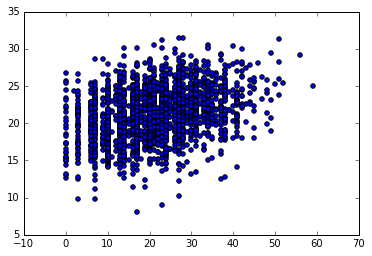

In [351]:
predictions = cross_val_predict(regressor, X_train_away, y_train_away, cv=10)
plt.scatter(y_train_away, predictions)
plt.show()

In [352]:
accuracy = metrics.r2_score(y_train_away, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.101848271185


In [353]:
#Add column of ones to account for b_0
X_train_away = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_away, axis = 1)
X_train_away[1]

array([  1.00000000e+00,  -2.00000000e-03,  -7.82857143e+00,
         6.28571429e+01,   2.29000000e-01,   9.10000000e+00,
         6.77142857e+00,   1.60285714e+01,   1.00000000e+00,
         1.57571429e+01,   1.00000000e+00,   3.91000000e-01])

In [354]:
X_opt = X_train_away[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     24.90
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.51e-49
Time:                        21:52:36   Log-Likelihood:                -7988.4
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2176   BIC:                         1.607e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9889      2.033      5.897      0.000       8.002      15.976
x1            -1.7877      4.075     -0.439      0.661      -9.779       6.203
x2             0.0550      0.040      1.372      0.170      -0.024       0.133
x3             0.2171      0.044      4.879      0.000       0.130       0.304
x4             2.9545      0.988      2.990      0.003       1.017       4.892
x5            -0.0017      0.075     -0.023      0.982      -0.149       0.146
x6            -0.0781      0.056     -1.385      0.166      -0.189       0.032
x7             0.0946      0.047      2.022      0.043       0.003       0.186
x8            -0.2449      0.461     -0.532      0.595      -1.149       0.659
x9            -0.0278      0.031     -0.908      0.364      -0.088       0.032
x10           -0.4368      0.519     -0.841      0.400      -1.456       0.582
x11            5.1694      0.937      5.516      0.000       3.332       7.007
==============================================================================
Omnibus:                       16.196   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.491
Skew:                           0.210   Prob(JB):                     0.000262
Kurtosis:                       2.928   Cond. No.                         958.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [355]:
X_opt = X_train_away[:, [0,1,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     27.41
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           8.38e-50
Time:                        21:52:37   Log-Likelihood:                -7988.4
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2177   BIC:                         1.606e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9890      2.033      5.898      0.000       8.003      15.975
x1            -1.7823      4.067     -0.438      0.661      -9.758       6.194
x2             0.0543      0.029      1.885      0.060      -0.002       0.111
x3             0.2169      0.044      4.919      0.000       0.130       0.303
x4             2.9546      0.988      2.991      0.003       1.017       4.892
x5            -0.0784      0.054     -1.447      0.148      -0.185       0.028
x6             0.0938      0.033      2.879      0.004       0.030       0.158
x7            -0.2449      0.461     -0.532      0.595      -1.148       0.659
x8            -0.0281      0.027     -1.055      0.292      -0.080       0.024
x9            -0.4364      0.519     -0.841      0.400      -1.454       0.581
x10            5.1716      0.932      5.548      0.000       3.344       6.999
==============================================================================
Omnibus:                       16.197   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.492
Skew:                           0.210   Prob(JB):                     0.000262
Kurtosis:                       2.928   Cond. No.                         950.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [356]:
X_opt = X_train_away[:, [0,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     30.44
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           1.62e-50
Time:                        21:52:38   Log-Likelihood:                -7988.5
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2178   BIC:                         1.605e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0384      2.029      5.933      0.000       8.059      16.018
x1             0.0548      0.029      1.904      0.057      -0.002       0.111
x2             0.2158      0.044      4.903      0.000       0.129       0.302
x3             2.9389      0.987      2.977      0.003       1.003       4.875
x4            -0.0766      0.054     -1.418      0.156      -0.183       0.029
x5             0.0947      0.033      2.914      0.004       0.031       0.158
x6            -0.2449      0.461     -0.532      0.595      -1.148       0.658
x7            -0.0278      0.027     -1.044      0.297      -0.080       0.024
x8            -0.4385      0.519     -0.845      0.398      -1.456       0.579
x9             5.0995      0.917      5.559      0.000       3.301       6.898
==============================================================================
Omnibus:                       16.171   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.465
Skew:                           0.209   Prob(JB):                     0.000266
Kurtosis:                       2.928   Cond. No.                         478.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [357]:
X_opt = X_train_away[:, [0,2,3,4,6,7,8,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     34.11
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.54e-51
Time:                        21:52:38   Log-Likelihood:                -7989.0
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2179   BIC:                         1.605e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1018      2.028      5.967      0.000       8.124      16.079
x1             0.0583      0.029      2.038      0.042       0.002       0.114
x2             0.2107      0.044      4.817      0.000       0.125       0.297
x3             2.9363      0.987      2.975      0.003       1.000       4.872
x4            -0.0886      0.053     -1.678      0.093      -0.192       0.015
x5             0.1000      0.032      3.115      0.002       0.037       0.163
x6            -0.2712      0.460     -0.590      0.556      -1.173       0.631
x7            -0.4707      0.518     -0.909      0.364      -1.486       0.545
x8             5.1287      0.917      5.594      0.000       3.331       6.927
==============================================================================
Omnibus:                       16.570   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.881
Skew:                           0.213   Prob(JB):                     0.000216
Kurtosis:                       2.934   Cond. No.                         472.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [358]:
X_opt = X_train_away[:, [0,2,3,4,7,8,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     38.55
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           2.79e-51
Time:                        21:52:39   Log-Likelihood:                -7990.5
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2180   BIC:                         1.604e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5995      2.007      6.277      0.000       8.663      16.536
x1             0.0481      0.028      1.721      0.085      -0.007       0.103
x2             0.2006      0.043      4.628      0.000       0.116       0.286
x3             2.9252      0.988      2.962      0.003       0.989       4.862
x4             0.0816      0.030      2.703      0.007       0.022       0.141
x5            -0.2507      0.460     -0.545      0.586      -1.153       0.651
x6            -0.5399      0.516     -1.045      0.296      -1.553       0.473
x7             4.3368      0.786      5.515      0.000       2.795       5.879
==============================================================================
Omnibus:                       16.556   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.865
Skew:                           0.212   Prob(JB):                     0.000218
Kurtosis:                       2.930   Cond. No.                         469.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [359]:
X_opt = X_train_away[:, [0,2,3,7,8,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     43.36
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           2.97e-50
Time:                        21:52:39   Log-Likelihood:                -7994.8
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2181   BIC:                         1.604e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1319      2.005      6.052      0.000       8.201      16.063
x1             0.0390      0.028      1.401      0.161      -0.016       0.094
x2             0.2077      0.043      4.789      0.000       0.123       0.293
x3             0.0922      0.030      3.073      0.002       0.033       0.151
x4            -0.2590      0.461     -0.562      0.574      -1.163       0.645
x5            -0.3941      0.515     -0.765      0.444      -1.404       0.616
x6             4.5290      0.785      5.768      0.000       2.989       6.069
==============================================================================
Omnibus:                       17.548   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.895
Skew:                           0.219   Prob(JB):                     0.000130
Kurtosis:                       2.929   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [360]:
X_opt = X_train_away[:, [0,2,3,7,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     51.98
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.56e-51
Time:                        21:52:39   Log-Likelihood:                -7995.0
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2182   BIC:                         1.604e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9299      1.972      6.050      0.000       8.063      15.797
x1             0.0412      0.028      1.497      0.135      -0.013       0.095
x2             0.2076      0.043      4.788      0.000       0.123       0.293
x3             0.0925      0.030      3.081      0.002       0.034       0.151
x4            -0.2555      0.452     -0.565      0.572      -1.142       0.631
x5             4.5401      0.785      5.785      0.000       3.001       6.079
==============================================================================
Omnibus:                       17.402   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.742
Skew:                           0.218   Prob(JB):                     0.000140
Kurtosis:                       2.928   Cond. No.                         459.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [361]:
X_opt = X_train_away[:, [0,2,3,7,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     64.92
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           6.20e-52
Time:                        21:52:42   Log-Likelihood:                -7995.2
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2183   BIC:                         1.603e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7554      1.947      6.037      0.000       7.937      15.574
x1             0.0426      0.027      1.553      0.121      -0.011       0.096
x2             0.2074      0.043      4.785      0.000       0.122       0.292
x3             0.0926      0.030      3.085      0.002       0.034       0.151
x4             4.5587      0.784      5.815      0.000       3.021       6.096
==============================================================================
Omnibus:                       17.274   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.607
Skew:                           0.216   Prob(JB):                     0.000150
Kurtosis:                       2.924   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [362]:
X_opt = X_train_away[:, [0,3,7,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     85.70
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           2.03e-52
Time:                        21:52:43   Log-Likelihood:                -7996.4
No. Observations:                2188   AIC:                         1.600e+04
Df Residuals:                    2184   BIC:                         1.602e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9789      1.882      5.832      0.000       7.287      14.670
x1             0.2208      0.042      5.195      0.000       0.137       0.304
x2             0.0904      0.030      3.016      0.003       0.032       0.149
x3             4.6339      0.783      5.920      0.000       3.099       6.169
==============================================================================
Omnibus:                       16.748   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.049
Skew:                           0.212   Prob(JB):                     0.000199
Kurtosis:                       2.913   Cond. No.                         438.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [363]:
# Optimal model using alpha < 0.05 significance level ^
X_test_away.shape

(548, 11)

In [364]:
# Now use this model to make predictions on the test set
X_test_away = np.append(arr = np.ones((548,1)).astype(int), values = X_test_away, axis = 1)
X_test_away = X_test_away[:, [0,3,7,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_away)
y_pred_away = regressor.predict(X_test_away)

In [365]:
print(mean_squared_error(y_test_away, y_pred_away))

93.9511001333


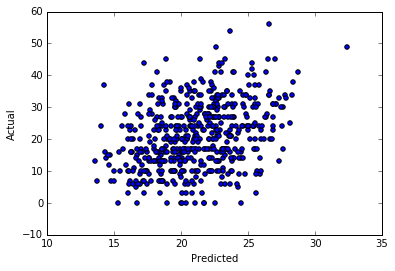

In [366]:
plt.scatter(y_pred_away, y_test_away)
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [367]:
from scipy.stats import pearsonr
pearsonr(y_test_away,y_pred_away)

(array([ 0.34910321]), array([  3.76531226e-17]))

We can see a pretty clear positive correlation between our predicted and actual values for away teams. The pearson correlation comes out as .349, with an extremely  low p-value

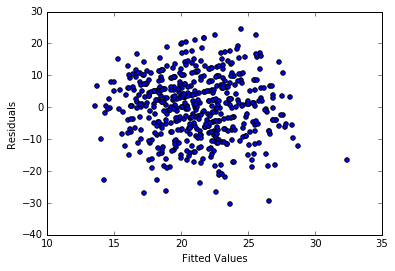

In [368]:
residuals = y_pred_away - y_test_away
plt.scatter(y_pred_away, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

There is no clear pattern among the fitted vs. residuals plot, so there are no issues. One thing to note is that the residuals tend to be a bit more negative than positive. One reason for this might be that it is much easier for an NFL team to not play well and heavily underperform than it is for a team to play so well that they outperform their prediction by 20+ points.

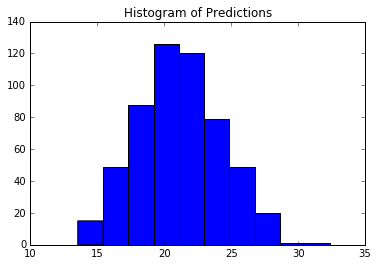

In [369]:
plt.hist(y_pred_away)
plt.title("Histogram of Predictions")
plt.show()

The histogram of our predictions is clearly normal, and centered around the 20-22 range. There may be one or two predictions above 30, but nothing out of the ordinary here.

In [370]:
import statsmodels.api as sm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline 

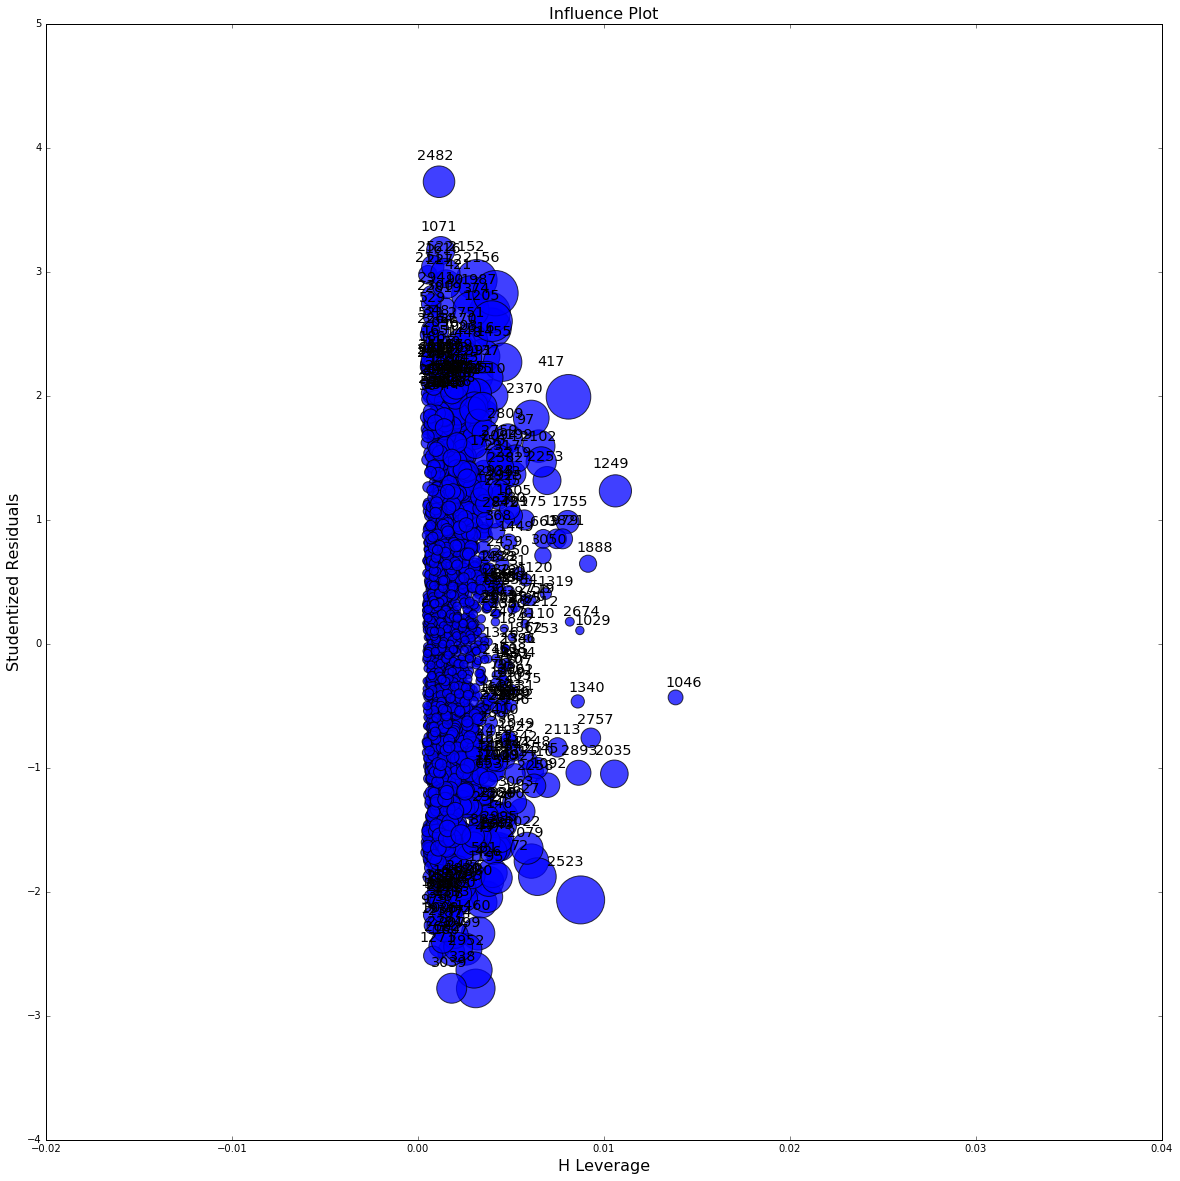

In [371]:
fig, ax = plt.subplots(figsize=(20,20))
fig = sm.graphics.influence_plot(regressor_OLS, criterion="cooks",size=48,ax=ax)

There doesn't seem to be anything out of the ordinary with the influence plot, so we shouldn't need to remove any data from the awayMatchup table. Let's move on to the home table.

In [376]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,random_state=732)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_home.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

X_train_home = X_train_home[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

X_test_home = X_test_home[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

In [377]:
X_train_home.head()

,stDvoa,runMatchup,ptsMatchup,offDvoaMatchup,offMatchup,ovrMatchup,passMatchup,surface,pblkMatchup,roof,totalDvoaMatchup
2759,-0.006,-10.785714,30.142857,-0.404,-11.571429,-13.314286,-15.042857,0,6.328571,1,-0.795
1665,0.015,-2.871429,39.571429,-0.155,0.342857,-6.771429,-7.128571,1,6.814286,1,-0.391
479,-0.051,-9.685714,54.428571,0.163,-3.671429,3.028571,-6.757143,0,13.642857,1,0.198
1319,0.047,0.400000,60.571429,0.271,17.542857,19.014286,15.414286,1,16.957143,1,0.833
189,-0.049,-6.928571,47.000000,-0.113,9.428571,5.714286,10.514286,1,17.042857,1,0.166


In [378]:
regressor = LinearRegression()
regressor.fit(X_train_home, y_train_home)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [379]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_home, y_train_home, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.15385157  0.07707133  0.10557638  0.13408471  0.07165699  0.00732515
  0.0865259   0.16447666  0.13682742  0.1138354 ]


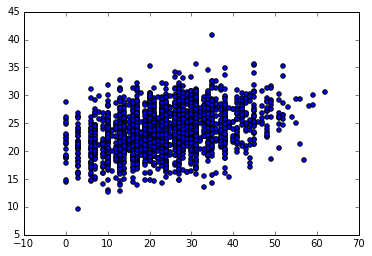

In [380]:
predictions = cross_val_predict(regressor, X_train_home, y_train_home, cv=10)
plt.scatter(y_train_home, predictions)
plt.show()

In [381]:
accuracy = metrics.r2_score(y_train_home, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.114538364482


In [382]:
X_train_home.shape

(2188, 11)

In [383]:
#Add column of ones to account for b_0
X_train_home = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_home, axis = 1)
X_train_home[1]

array([  1.00000000e+00,   1.50000000e-02,  -2.87142857e+00,
         3.95714286e+01,  -1.55000000e-01,   3.42857143e-01,
        -6.77142857e+00,  -7.12857143e+00,   1.00000000e+00,
         6.81428571e+00,   1.00000000e+00,  -3.91000000e-01])

In [384]:
X_opt = X_train_home[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     28.49
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           2.20e-56
Time:                        21:55:42   Log-Likelihood:                -8123.4
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2176   BIC:                         1.634e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2838      2.165      6.136      0.000       9.038      17.530
x1             5.2250      4.369      1.196      0.232      -3.343      13.793
x2             0.0263      0.042      0.628      0.530      -0.056       0.108
x3             0.2189      0.047      4.680      0.000       0.127       0.311
x4             4.8225      1.027      4.694      0.000       2.808       6.837
x5             0.0139      0.080      0.173      0.862      -0.143       0.171
x6            -0.0400      0.059     -0.677      0.499      -0.156       0.076
x7             0.0751      0.049      1.529      0.126      -0.021       0.171
x8             1.1378      0.495      2.300      0.022       0.168       2.108
x9             0.0852      0.033      2.601      0.009       0.021       0.149
x10           -0.8298      0.549     -1.511      0.131      -1.907       0.247
x11            4.7185      1.008      4.682      0.000       2.742       6.695
==============================================================================
Omnibus:                       28.938   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.759
Skew:                           0.283   Prob(JB):                     3.45e-07
Kurtosis:                       3.072   Cond. No.                         958.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [392]:
X_opt = X_train_home[:, [0,1,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     31.31
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           4.63e-57
Time:                        21:57:10   Log-Likelihood:                -8123.6
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2177   BIC:                         1.633e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0632      2.136      6.115      0.000       8.874      17.252
x1             5.3212      4.366      1.219      0.223      -3.240      13.882
x2             0.2202      0.047      4.715      0.000       0.129       0.312
x3             4.7660      1.023      4.658      0.000       2.759       6.773
x4             0.0496      0.057      0.877      0.381      -0.061       0.161
x5            -0.0407      0.059     -0.688      0.492      -0.157       0.075
x6             0.0575      0.040      1.426      0.154      -0.022       0.136
x7             1.1432      0.494      2.312      0.021       0.174       2.113
x8             0.0765      0.030      2.577      0.010       0.018       0.135
x9            -0.8242      0.549     -1.501      0.134      -1.901       0.253
x10            4.7238      1.008      4.688      0.000       2.748       6.700
==============================================================================
Omnibus:                       29.358   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.205
Skew:                           0.285   Prob(JB):                     2.76e-07
Kurtosis:                       3.076   Cond. No.                         954.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [393]:
X_opt = X_train_home[:, [0,1,3,4,5,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     34.74
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           9.59e-58
Time:                        21:57:46   Log-Likelihood:                -8123.8
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2178   BIC:                         1.632e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2471      2.119      6.251      0.000       9.092      17.403
x1             5.6054      4.346      1.290      0.197      -2.916      14.127
x2             0.2182      0.047      4.681      0.000       0.127       0.310
x3             4.7440      1.023      4.639      0.000       2.738       6.749
x4             0.0360      0.053      0.679      0.497      -0.068       0.140
x5             0.0556      0.040      1.383      0.167      -0.023       0.134
x6             1.1119      0.492      2.259      0.024       0.146       2.077
x7             0.0755      0.030      2.548      0.011       0.017       0.134
x8            -0.8350      0.549     -1.521      0.128      -1.911       0.241
x9             4.3634      0.861      5.069      0.000       2.675       6.052
==============================================================================
Omnibus:                       29.295   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.139
Skew:                           0.285   Prob(JB):                     2.85e-07
Kurtosis:                       3.074   Cond. No.                         949.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [394]:
X_opt = X_train_home[:, [0,1,3,4,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     39.03
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           1.86e-58
Time:                        21:58:03   Log-Likelihood:                -8124.1
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2179   BIC:                         1.632e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9716      2.080      6.237      0.000       8.893      17.050
x1             5.3961      4.334      1.245      0.213      -3.103      13.895
x2             0.2260      0.045      5.008      0.000       0.138       0.315
x3             4.6802      1.018      4.596      0.000       2.683       6.677
x4             0.0723      0.032      2.277      0.023       0.010       0.135
x5             1.1050      0.492      2.245      0.025       0.140       2.070
x6             0.0824      0.028      2.956      0.003       0.028       0.137
x7            -0.8605      0.548     -1.571      0.116      -1.934       0.213
x8             4.4160      0.857      5.152      0.000       2.735       6.097
==============================================================================
Omnibus:                       29.515   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.373
Skew:                           0.286   Prob(JB):                     2.54e-07
Kurtosis:                       3.076   Cond. No.                         941.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [395]:
X_opt = X_train_home[:, [0,3,4,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     44.38
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           5.74e-59
Time:                        21:58:19   Log-Likelihood:                -8124.9
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2180   BIC:                         1.631e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7678      2.073      6.158      0.000       8.702      16.834
x1             0.2290      0.045      5.079      0.000       0.141       0.317
x2             4.7476      1.017      4.669      0.000       2.753       6.742
x3             0.0691      0.032      2.183      0.029       0.007       0.131
x4             1.1944      0.487      2.453      0.014       0.240       2.149
x5             0.0809      0.028      2.907      0.004       0.026       0.136
x6            -0.7849      0.544     -1.442      0.149      -1.852       0.282
x7             4.5645      0.849      5.376      0.000       2.900       6.229
==============================================================================
Omnibus:                       30.148   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.055
Skew:                           0.289   Prob(JB):                     1.81e-07
Kurtosis:                       3.074   Cond. No.                         460.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [397]:
X_opt = X_train_home[:, [0,3,4,7,8,9,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     51.40
Date:                Wed, 17 Jul 2019   Prob (F-statistic):           2.13e-59
Time:                        21:59:51   Log-Likelihood:                -8125.9
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2181   BIC:                         1.631e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9832      2.001      5.988      0.000       8.059      15.908
x1             0.2309      0.045      5.123      0.000       0.142       0.319
x2             4.7161      1.017      4.638      0.000       2.722       6.710
x3             0.0714      0.032      2.256      0.024       0.009       0.133
x4             1.5225      0.431      3.535      0.000       0.678       2.367
x5             0.0775      0.028      2.795      0.005       0.023       0.132
x6             4.4389      0.845      5.255      0.000       2.782       6.095
==============================================================================
Omnibus:                       29.941   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.825
Skew:                           0.288   Prob(JB):                     2.02e-07
Kurtosis:                       3.080   Cond. No.                         443.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [399]:
X_test_home.shape

(548, 11)

In [400]:
# Now use this model to make predictions on the test set
X_test_home = np.append(arr = np.ones((548,1)).astype(int), values = X_test_home, axis = 1)
X_test_home = X_test_home[:, [0,3,4,7,8,9,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_home)
y_pred_home = regressor.predict(X_test_home)

In [402]:
print(mean_squared_error(y_test_home, y_pred_home))

97.4283133169


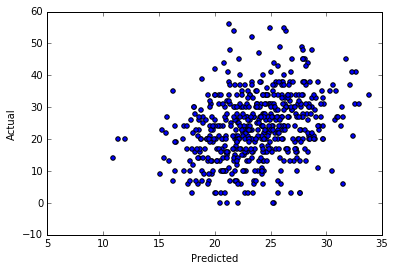

In [403]:
plt.scatter(y_pred_home, y_test_home)
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [404]:
from scipy.stats import pearsonr
pearsonr(y_test_home,y_pred_home)

(array([ 0.31058148]), array([  1.01709500e-13]))

We can see a pretty clear positive correlation between our predicted and actual values for home teams. The pearson correlation comes out as .311, with an extremely  low p-value

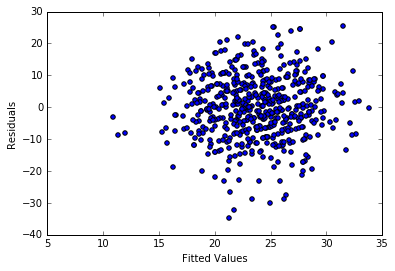

In [405]:
residuals = y_pred_home - y_test_home
plt.scatter(y_pred_home, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

There is no clear pattern among the fitted vs. residuals plot, so there are no issues. We may want to explore the three points to the left.

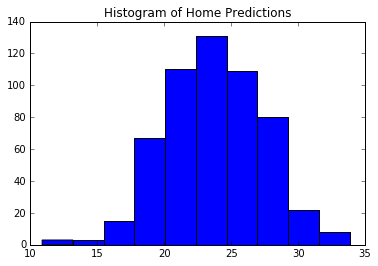

In [406]:
plt.hist(y_pred_home)
plt.title("Histogram of Home Predictions")
plt.show()

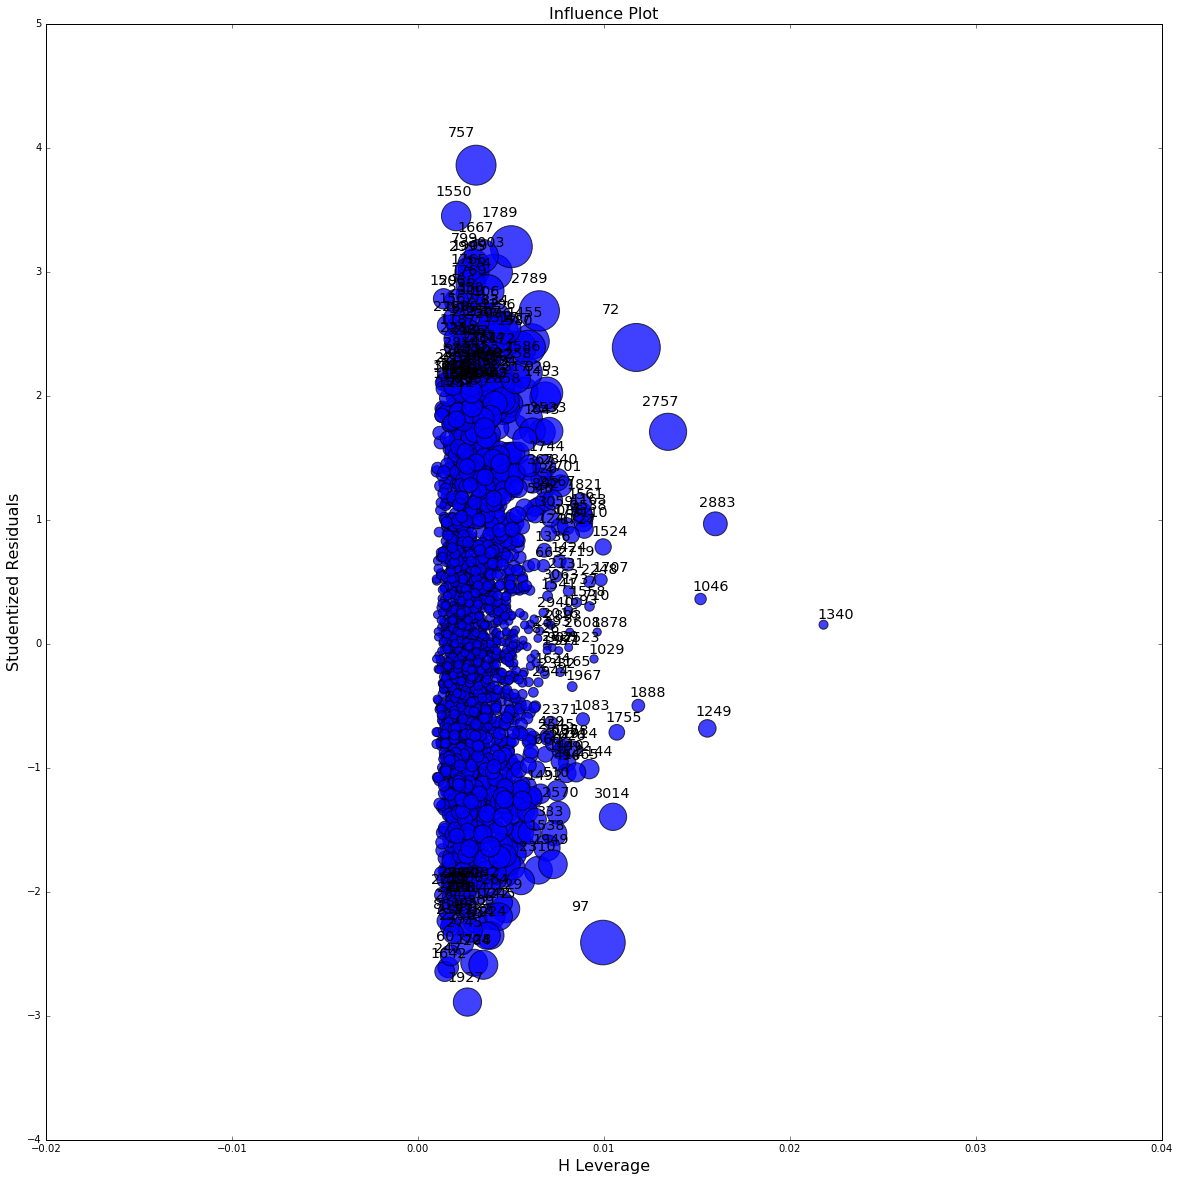

In [407]:
fig, ax = plt.subplots(figsize=(20,20))
fig = sm.graphics.influence_plot(regressor_OLS, criterion="cooks",size=48,ax=ax)

There doesn't seem to be anything out of the ordinary with the influence plot, so we shouldn't need to remove any data from the homeMatchup table. Now let's put it all together and make predictions for total scores between home and away teams.

In [413]:
y_test_away = y_test_away.reset_index()
y_test_away = y_test_away[['pf']]
y_test_home = y_test_home.reset_index()
y_test_home = y_test_home[['pf']]

In [414]:
y_test_away

,pf
0,13
1,14
2,17
3,14
4,37
5,27
6,49
7,13
8,34
9,31


In [422]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [423]:
testDf = testDf.rename(index=int, columns = {1:'ptsMatchup',2:'passMatchup',3:'totalDvoaMatchup'})
testDf = testDf.drop(0,axis=1)
testDf

,ptsMatchup,passMatchup,totalDvoaMatchup,awayScore,awayPrediction
0,38.142857,-15.542857,-0.245,13,16.858639
1,41.714286,-1.057143,-0.130,14,19.490063
2,36.857143,6.185714,-0.367,17,17.974546
3,35.285714,-7.185714,-0.801,14,14.407212
4,54.857143,1.914286,0.551,37,25.816034
5,43.285714,-22.000000,-0.076,27,18.193184
6,46.000000,5.942857,0.193,49,22.566041
7,39.142857,0.171429,-0.289,13,18.296686
8,50.285714,9.642857,-0.053,34,22.706870
9,46.428571,-1.214286,0.298,31,22.499940


In [424]:
testDf2.head()

,0,1,2,3,4,5,6,homeScore,homePrediction
0,1.0,48.714286,-0.087,12.771429,0.0,8.428571,0.245,17,25.472621
1,1.0,46.142857,-0.161,3.928571,1.0,7.942857,0.130,31,24.873309
2,1.0,50.714286,0.010,26.642857,1.0,2.400000,0.367,20,28.978279
3,1.0,57.714286,-0.134,5.500000,0.0,13.871429,0.801,33,29.700122
4,1.0,34.857143,-0.060,-6.157143,0.0,14.528571,-0.551,3,17.989506


In [425]:
testDf2 = testDf2.rename(index=int, columns = {1:'ptsMatchup',2:'offDvoaMatchup',3:'passMatchup',4:'surface', 5: 'pblkMatchup',6:'totalDvoaMatchup'})
testDf2 = testDf2.drop(0,axis=1)
testDf2

,ptsMatchup,offDvoaMatchup,passMatchup,surface,pblkMatchup,totalDvoaMatchup,homeScore,homePrediction
0,48.714286,-0.087,12.771429,0.0,8.428571,0.245,17,25.472621
1,46.142857,-0.161,3.928571,1.0,7.942857,0.130,31,24.873309
2,50.714286,0.010,26.642857,1.0,2.400000,0.367,20,28.978279
3,57.714286,-0.134,5.500000,0.0,13.871429,0.801,33,29.700122
4,34.857143,-0.060,-6.157143,0.0,14.528571,-0.551,3,17.989506
5,54.857143,0.107,-4.700000,0.0,-1.600000,0.076,17,25.031327
6,34.571429,-0.404,0.500000,0.0,8.657143,-0.193,26,17.910100
7,48.714286,0.074,19.328571,1.0,-0.585714,0.289,31,27.718672
8,46.571429,0.137,-4.400000,1.0,1.142857,0.053,31,24.914289
9,40.285714,0.021,-4.300000,1.0,13.928571,-0.298,17,22.356432


In [433]:
# Join awayMatchup table with away predictions and do same for home team. make sure to take out surface column
# since it is now binary, and wasn't in theoriginal table

colsAway = list(testDf.columns)
colsAway.pop(-1)
colsAway.pop(-1)
colsAway
colsHome = list(testDf2.columns)
colsHome.pop(-1)
colsHome.pop(-1)
colsHome.pop(-3)
colsHome
# # cols.pop(7)
# # cols.pop(7)

['ptsMatchup',
 'offDvoaMatchup',
 'passMatchup',
 'pblkMatchup',
 'totalDvoaMatchup']

In [434]:
awayPredDf = awayMatchup.merge(testDf, on=colsAway)
homePredDf = homeMatchup.merge(testDf2, on=colsHome)

In [435]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
#awayHomeMerge.columns

In [436]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201812300sea,2018-12-30,2018,17,16.016217,31.060155
1,201712170was,2017-12-17,2017,15,19.797574,22.202233
2,201611270atl,2016-11-27,2016,12,20.880465,28.576235
3,201610060sfo,2016-10-06,2016,5,20.772308,22.490529
4,201811250sdg,2018-11-25,2018,12,15.393467,28.061623


In [437]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
#finalDf.columns

In [438]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [439]:
finalDf.head()

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,201011210kan,2010-11-21,2010,11,Arizona Cardinals,17.585399,13,Kansas City Chiefs,27.477793,31,45.0,under,45.063191,44
1,201501030car,2015-01-03,2014,18,Arizona Cardinals,16.283054,16,Carolina Panthers,23.538400,27,37.5,over,39.821453,43
2,201012190car,2010-12-19,2010,15,Arizona Cardinals,21.696719,12,Carolina Panthers,19.619271,19,37.5,under,41.315990,31
3,201111200sfo,2011-11-20,2011,11,Arizona Cardinals,14.779787,7,San Francisco 49ers,25.087069,23,40.5,under,39.866856,30
4,201812300sea,2018-12-30,2018,17,Arizona Cardinals,16.016217,24,Seattle Seahawks,31.060155,27,39.5,over,47.076372,51


In [440]:
finalDf[finalDf['season'] == 2018]

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
4,201812300sea,2018-12-30,2018,17,Arizona Cardinals,16.016217,24,Seattle Seahawks,31.060155,27,39.5,over,47.076372,51
17,201811250sdg,2018-11-25,2018,12,Arizona Cardinals,15.393467,10,Los Angeles Chargers,28.061623,45,43.0,over,43.455090,55
18,201810140min,2018-10-14,2018,6,Arizona Cardinals,20.208839,17,Minnesota Vikings,24.079259,27,43.5,over,44.288097,44
38,201811220nor,2018-11-22,2018,12,Atlanta Falcons,20.491601,17,New Orleans Saints,32.967888,31,61.5,under,53.459489,48
42,201812300tam,2018-12-30,2018,17,Atlanta Falcons,21.498291,34,Tampa Bay Buccaneers,21.075148,32,51.5,over,42.573439,66
49,201810070cle,2018-10-07,2018,5,Baltimore Ravens,25.602006,9,Cleveland Browns,18.074037,12,44.5,under,43.676044,21
70,201810210clt,2018-10-21,2018,7,Buffalo Bills,16.637779,5,Indianapolis Colts,26.640112,37,43.5,under,43.277891,42
105,201812230sfo,2018-12-23,2018,16,Chicago Bears,23.693568,14,San Francisco 49ers,19.459914,9,44.0,under,43.153482,23
109,201811040buf,2018-11-04,2018,9,Chicago Bears,23.946486,41,Buffalo Bills,15.135948,9,38.0,over,39.082434,50
115,201809230crd,2018-09-23,2018,3,Chicago Bears,24.270462,16,Arizona Cardinals,10.881899,14,39.0,under,35.152362,30


In [450]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 5]
undersDf['result'].value_counts()

under    14
over      9
Name: result, dtype: int64

In [451]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 3]
undersDf['result'].value_counts()

under    39
over     32
push      1
Name: result, dtype: int64

In [452]:
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 1]
undersDf['result'].value_counts()

under    82
over     80
push      2
Name: result, dtype: int64

In [453]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 5]
oversDf['result'].value_counts()

over     21
under    11
push      2
Name: result, dtype: int64

In [454]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf['result'].value_counts()

over     53
under    48
push      2
Name: result, dtype: int64

In [455]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 1]
oversDf['result'].value_counts()

over     115
under    107
push       3
Name: result, dtype: int64